In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Conv1D, Bidirectional, LSTM
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Reshape, Dropout
from tensorflow.keras.models import Sequential
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
vocab_size = 1500
embedding_dim = 100
max_length = 20
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 800

In [ ]:
df=pd.read_excel('Dataset_cyberbullying.xlsx')
sentences = df['Comment']
labels = df["Class"]

In [ ]:
def remove_punctuation_and_numbers(text):
    return re.sub(r'[^\w\s]|[\d]', '', text)
sentences=sentences.apply(remove_punctuation_and_numbers)

In [ ]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [ ]:
import json
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
with open("words.json", "w") as outfile:
    json.dump(dict(sorted(tokenizer.word_index.items())), outfile, indent=4, separators=(',', ': '))
dict(sorted(tokenizer.word_index.items()))

{'<OOV>': 1,
 'a': 762,
 'aa': 695,
 'aaa': 1525,
 'aaaa': 997,
 'aamiin': 320,
 'aamiinn': 2400,
 'abaikan': 1940,
 'abang': 566,
 'abg': 978,
 'abis': 893,
 'acara': 3013,
 'acaranya': 2137,
 'acting': 2439,
 'ad': 2986,
 'ada': 14,
 'adaberarti': 3151,
 'adakah': 2321,
 'adalah': 247,
 'adam': 1275,
 'adanya': 1959,
 'adat': 1510,
 'ade': 2131,
 'adee': 1491,
 'adek': 604,
 'adem': 525,
 'adik': 990,
 'adikmu': 1641,
 'adopsi': 2002,
 'aduh': 2349,
 'aduhaii': 1213,
 'aduhhhh': 1854,
 'aelah': 1280,
 'aer': 1413,
 'agak': 715,
 'agama': 468,
 'agamanya': 2199,
 'agar': 890,
 'age': 2608,
 'agnes': 1508,
 'agnesmo': 1270,
 'agnez': 841,
 'agustus': 1758,
 'ah': 422,
 'ahahaha': 2312,
 'ahh': 3004,
 'ahhaha': 2202,
 'aih': 1180,
 'aik': 2530,
 'ain': 3190,
 'aing': 2294,
 'air': 2047,
 'aj': 1034,
 'aja': 9,
 'ajaa': 2774,
 'ajagag': 1681,
 'ajah': 2524,
 'ajak': 696,
 'ajalah': 1284,
 'aje': 706,
 'ajg': 183,
 'ajgg': 713,
 'ajh': 1703,
 'ajk': 1540,
 'ak': 1087,
 'akad': 925,
 'akad

In [ ]:
# Manual modifications applied on words.json, then imported to tokenizer
with open('words.json', 'r') as f:
    word_index = json.load(f)
tokenizer.word_index = word_index

In [ ]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type)

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [ ]:
def AlexNet(vocab_size, embedding_dim, max_length):
    input_layer=Input((max_length,))
    embedding=(Embedding(vocab_size, embedding_dim))(input_layer)
    reshape=Reshape((max_length, embedding_dim, 1))(embedding)

    # First branch
    branch1 = Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                     padding='same', activation='relu')(reshape)
    branch1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(branch1)

    # Second branch
    branch2 = Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                     padding='same', activation='relu')(reshape)
    branch2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(branch2)

    # Third branch
    branch3 = Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                     padding='same', activation='relu')(reshape)
    branch3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(branch3)

    # Concatenate branches
    concatenated = concatenate([branch1, branch2, branch3])

    # Fully connected layers
    flatten = Flatten()(concatenated)
    d = Dense(256, activation='relu')(flatten)
    do = Dropout(0.5)(d)

    # Output layer
    output = Dense(1, activation='sigmoid')(do)

    model = tf.keras.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model
model = AlexNet(vocab_size, embedding_dim, max_length)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 20, 100)              150000    ['input_7[0][0]']             
                                                                                                  
 reshape_6 (Reshape)         (None, 20, 100, 1)           0         ['embedding_6[0][0]']         
                                                                                                  
 conv2d_18 (Conv2D)          (None, 20, 100, 32)          320       ['reshape_6[0][0]']           
                                                                                            

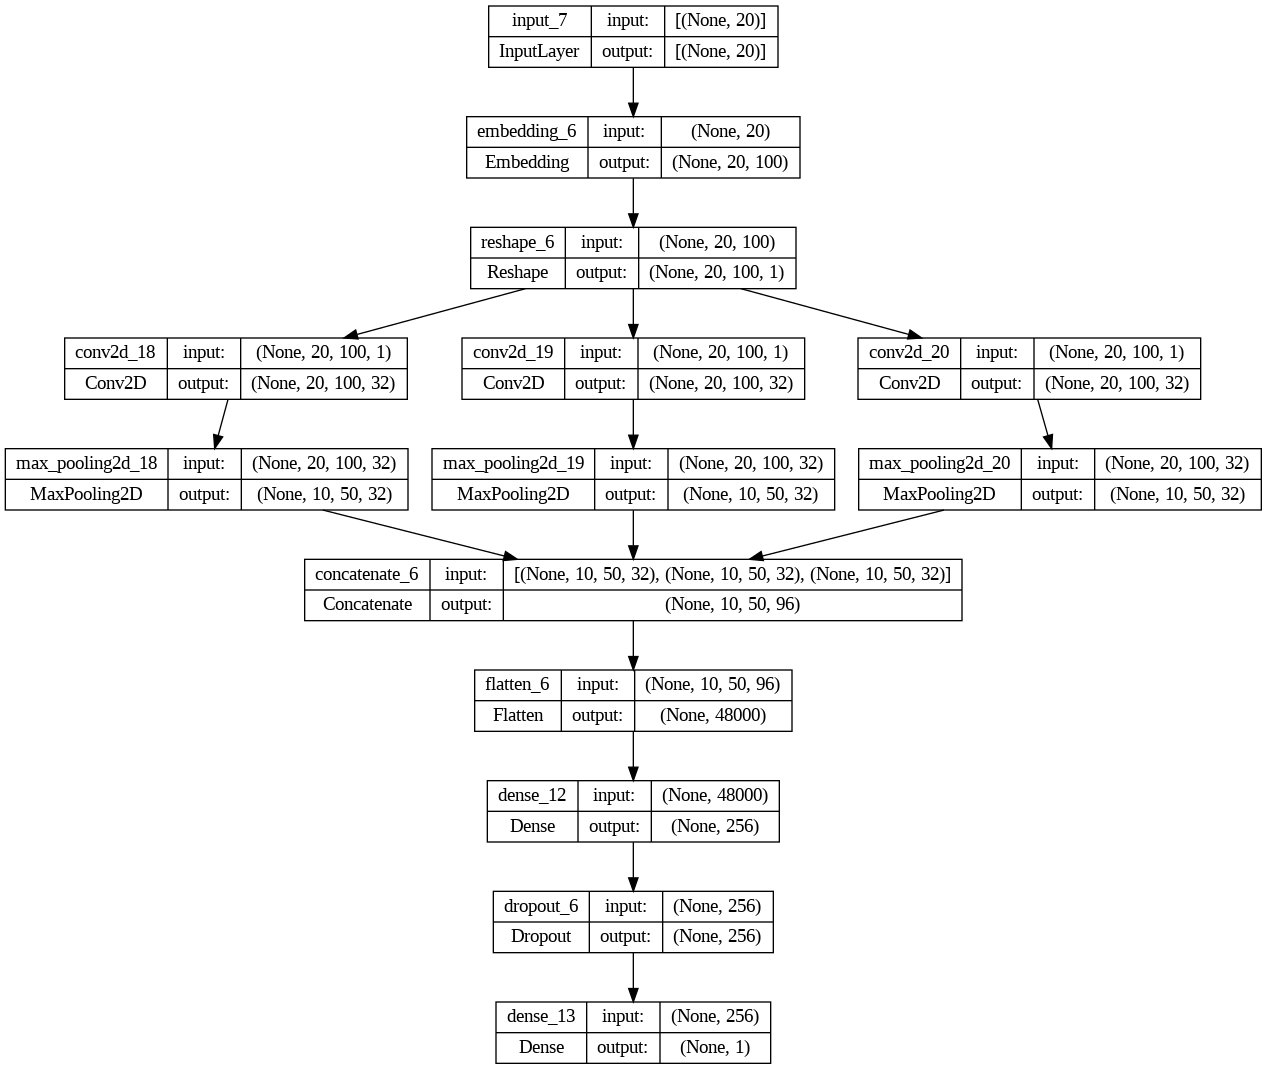

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history=model.fit(training_padded, training_labels, validation_data=(testing_padded, testing_labels), epochs=5)

Epoch 1/5
25/25 [==============================] - 12s 383ms/step - loss: 0.6783 - accuracy: 0.5950 - val_loss: 0.6460 - val_accuracy: 0.6400
Epoch 2/5
25/25 [==============================] - 10s 416ms/step - loss: 0.5375 - accuracy: 0.7212 - val_loss: 0.5606 - val_accuracy: 0.6950
Epoch 3/5
25/25 [==============================] - 11s 426ms/step - loss: 0.2763 - accuracy: 0.9038 - val_loss: 0.3979 - val_accuracy: 0.8250
Epoch 4/5
25/25 [==============================] - 10s 392ms/step - loss: 0.0861 - accuracy: 0.9762 - val_loss: 0.4633 - val_accuracy: 0.8250
Epoch 5/5
25/25 [==============================] - 12s 496ms/step - loss: 0.0269 - accuracy: 0.9950 - val_loss: 0.5201 - val_accuracy: 0.8150


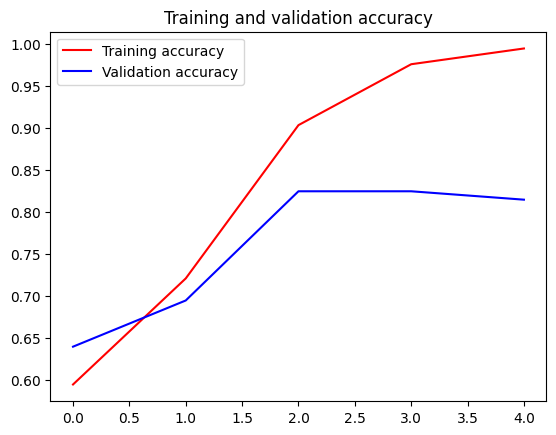

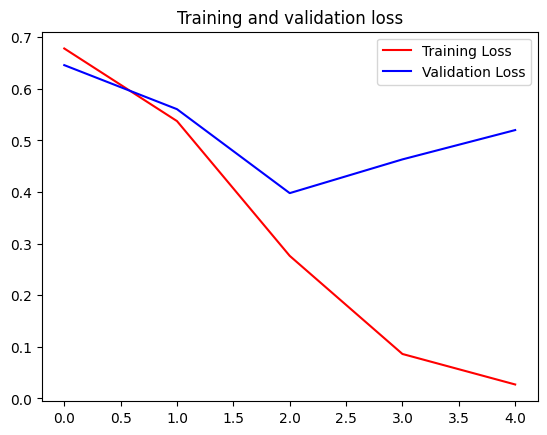

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Get the index-word dictionary
reverse_word_index = tokenizer.index_word

# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[1]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape)

(1500, 100)


In [ ]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

In [ ]:
# Import files utilities in Colab
try:
  from google.colab import files
except ImportError:
  pass

# Download the files
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save("mymodel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
